**Grid Search** Random Forest

In [3]:
import pandas as pd 
import numpy as np
import os 
import sys 
import matplotlib.pyplot as plt
import seaborn as sns
path = r'C:\Users\nynne\Dropbox\Polit\Topics in Social Data Science\ExamProject\data'

np.random.seed(33)

from datetime import datetime 
time_start = datetime.now()

###############################################################################
### LOAD DATA
data_train = pd.read_csv(path + '\data_train.csv', index_col=0)
y = data_train['draw']
odds_prob = data_train['odds_prob_draw']
x = data_train[['ELO_home', 'ELO_away', 'home_agg_overall', 'home_def_overall',
                'away_agg_overall', 'away_def_overall', 'RR']]
x = x.join(pd.get_dummies(data_train['league']))#.reset_index(drop='index')))

###############################################################################
### IMPUTATION 
#Check for missing values 
print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
print('Missing values:\n', x.isnull().sum(), sep='')

## Performance metrics are missing because of burn-in.
## Fillout burnin based on later average. 
x = x.join(data_train[['team_home', 'team_awat']])
#x['home_agg_overall'] = x.groupby('team_home').transform(lambda a: a.fillna(a.mean()))
x.loc[x['home_agg_overall'].isnull(), 'home_agg_overall'] = x.groupby('team_home')['home_agg_overall'].transform('mean')
x.loc[x['home_def_overall'].isnull(), 'home_def_overall'] = x.groupby('team_home')['home_def_overall'].transform('mean')
x.loc[x['away_agg_overall'].isnull(), 'away_agg_overall'] = x.groupby('team_awat')['away_agg_overall'].transform('mean')
x.loc[x['away_def_overall'].isnull(), 'away_def_overall'] = x.groupby('team_awat')['away_def_overall'].transform('mean')
x.drop(['team_home', 'team_awat'], axis=1, inplace=True)

#from sklearn.preprocessing import Imputer
#x = Imputer(strategy='mean').fit_transform()
x = x.fillna(x.mean())


print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
#print('Missing values:\n', x.isnull().sum(), sep='')

###############################################################################
### STANDARDIZE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x.iloc[:,:7])
x.iloc[:,:7] = scaler.transform(x.iloc[:,:7])


Rows with any missing values: 0.42
Missing values:
ELO_home                    3899
ELO_away                    3897
home_agg_overall            1076
home_def_overall            1076
away_agg_overall            1066
away_def_overall            1066
RR                          1288
Belgium Jupiler League         0
England Premier League         0
France Ligue 1                 0
Germany 1. Bundesliga          0
Italy Serie A                  0
Netherlands Eredivisie         0
Poland Ekstraklasa             0
Portugal Liga ZON Sagres       0
Scotland Premier League        0
Spain LIGA BBVA                0
Switzerland Super League       0
dtype: int64
Rows with any missing values: 0.0


In [4]:
##################################################################################
#####################Define Functions#############################
def bet_income(y, prob, odds_prob, bet=1, threshold=0.0):
    will_bet = (prob>odds_prob+threshold) #Bet if probability high enough
    correct_bets = y[will_bet]          # Bet is correct if y==1. Select chosen bets. 
    odds = 1/odds_prob[will_bet]        # Calculate odds 
    
    #Calculate income
    income = correct_bets*odds*bet-will_bet*bet
    income = income.sum() #Sum over matrix 
    
    #Calculate income as multiplicator of necessary capital
    if will_bet.sum() != 0: 
        income_factor = income/will_bet.sum() #
    else: income_factor = 0
    
    return income_factor

def cross_val_bet(clf_cv, x, y, odds_prob):
    fold = KFold(n_splits=10, shuffle=True)
    profit = []
    for train, test in fold.split(x): 
        clf_cv.fit(x.iloc[train], y.iloc[train])
        yprob = clf_cv.predict_proba(x.iloc[test])
        profit.append(bet_income(y.iloc[test], yprob[:,1], odds_prob.iloc[test]))
    
    return np.mean(profit)

def cross_val_par(par, x, y, odds_prob): 
    timer = datetime.now()
    clf_cv = RandomForestClassifier(min_samples_split = 2,
                                    criterion = 'entropy',
                                    bootstrap = True,
                                    n_jobs=-1)
    result = par.copy()
    result = par.copy()
    result['cv_score'] = cross_val_bet(clf_cv, x, y, odds_prob)
    yprob_train = clf_cv.predict_proba(x)[:,1]
    result['in_sample_score'] = bet_income(y,yprob_train,odds_prob)
    result['timer'] = str(datetime.now()-timer)
    return result

def grid_search_bet_serial(grid, x, y, odds_prob): 
    cv_results = pd.DataFrame(columns=[key for key in [i for i in iter(grid)][0].keys()]+['cv_score', 'in_sample_score', 'timer'])
    for par in iter(grid): 
        result = cross_val_par(par,x,y,odds_prob)
        cv_results = cv_results.append(result, ignore_index=True)
    return cv_results

In [5]:
##################################################################################
####################Hyperparameter tuning#################
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

#Tuning parameters for the random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto','sqrt', 'log2']
min_samples_leaf = [10,50,100,200,300,400,500]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf
                }
grid = ParameterGrid(random_grid)

In [ ]:
grid_search = grid_search_bet_serial(grid,x,y,data_train.odds_prob_draw)
#Best fit
grid_search.iloc[grid_search.cv_score.argmax()]

C:\Users\nynne\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


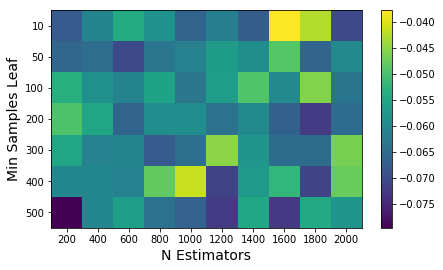

In [5]:
grid_plot2 = grid_search.groupby(['n_estimators','min_samples_leaf'])['cv_score'].mean().reset_index()
grid_plot = np.reshape(grid_plot2.cv_score,(len(min_samples_leaf),len(n_estimators)))

plt.figure(figsize=(7, 4))
plt.imshow(grid_plot)
plt.xlabel('N Estimators', fontsize=14)
plt.ylabel('Min Samples Leaf', fontsize=14)
plt.colorbar()
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(min_samples_leaf)), min_samples_leaf)
plt.show()

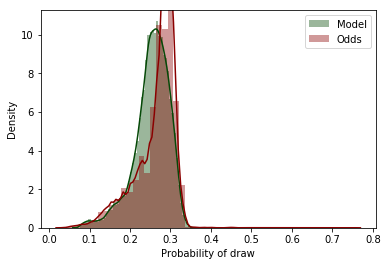

In [6]:
#Best fit 
clf = RandomForestClassifier(max_depth=None, 
                             max_features='auto', 
                             min_samples_leaf = 100,
                             n_estimators = 1600,
                             min_samples_split = 2,
                             criterion = 'entropy',
                             bootstrap = True, 
                             n_jobs=-1)

color = {0: 'xkcd:darkblue', 1: 'darkred',2: 'xkcd:magenta', 3:'xkcd:turquoise', 4:'xkcd:darkgreen', 5:'xkcd:maroon',6:'xkcd:silver' }

clf.fit(x,y)
odds_prob = data_train.odds_prob_draw
yhat = clf.predict(x)     
yprob = clf.predict_proba(x)
ax = sns.distplot(yprob[:,1], hist=True, kde=True, color=color[4], label='Model')
ax = sns.distplot(odds_prob.dropna(), hist=True, kde=True, color=color[1], label = 'Odds')
ax.set(xlabel= 'Probability of draw', ylabel = 'Density')
plt.legend()
plt.show()

Feature ranking:
1. feature 2 (0.216079)
2. feature 0 (0.188692)
3. feature 5 (0.123567)
4. feature 3 (0.119336)
5. feature 1 (0.119022)
6. feature 4 (0.114234)
7. feature 6 (0.058805)
8. feature 9 (0.011173)
9. feature 7 (0.008624)
10. feature 16 (0.007706)
11. feature 12 (0.006665)
12. feature 8 (0.005478)
13. feature 11 (0.005099)
14. feature 13 (0.004976)
15. feature 10 (0.003164)
16. feature 14 (0.002796)
17. feature 15 (0.002602)
18. feature 17 (0.001981)


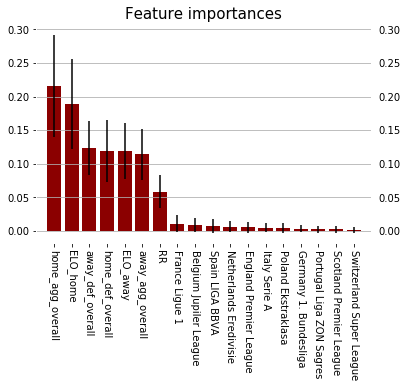

In [8]:
##################################################################################
#################### Feature importances #################
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
imp_names = np.vstack((importances,  list(x.columns.values))).T
imp_names = imp_names[imp_names[:, 0].argsort()[::-1]]
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(x.shape[1]):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

# Feature importances plot
plt.figure()
plt.title('Feature importances', fontsize=15)
plt.bar(range(x.shape[1]), importances[indices],
       color=color[1], yerr=std[indices], align='center')
plt.xticks(range(x.shape[1]), imp_names[:,1], rotation=-90)
plt.gca().yaxis.grid(True)
plt.tick_params(labeltop=False, labelright=True)
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['axes.linewidth'] = 1
plt.xlim([-1, x.shape[1]])
#plt.savefig('feature_importance.eps', format='eps',bbox_inches='tight')
plt.show()